In [51]:
import sqlite3
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import shap
import pickle

conn = sqlite3.connect("Chinook_Sqlite.sqlite")

In [52]:
query = "SELECT *\
    FROM \
    Invoice i\
    Left JOIN Customer c ON i.CustomerId = c.CustomerId\
    Left JOIN Employee e ON c.SupportRepId = e.EmployeeId\
    left JOIN InvoiceLine il ON i.InvoiceId = il.InvoiceId\
    left JOIN Track t ON il.TrackId = t.TrackId\
    left JOIN Album a ON t.AlbumId = a.AlbumId\
    left JOIN Artist ar ON a.ArtistId = ar.ArtistId\
    left JOIN Genre g ON t.GenreId = g.GenreId"

df = pd.read_sql(query, conn)
df = df.loc[:,~df.columns.duplicated()]
df = df.dropna()
# for d in ['InvoiceDate','BirthDate','HireDate']:
#     df[d] = pd.to_datetime(df[d], errors = 'coerce')
# for d in ['InvoiceDate','BirthDate','HireDate']:
#     df[f"{d}_Year"] = df[d].dt.year
#     df[f"{d}_Month"] = df[d].dt.month
#     df[f"{d}_Day"] = df[d].dt.day


# df.info()

RMSE: 6.76
Cross-Validation RMSE: 38.71


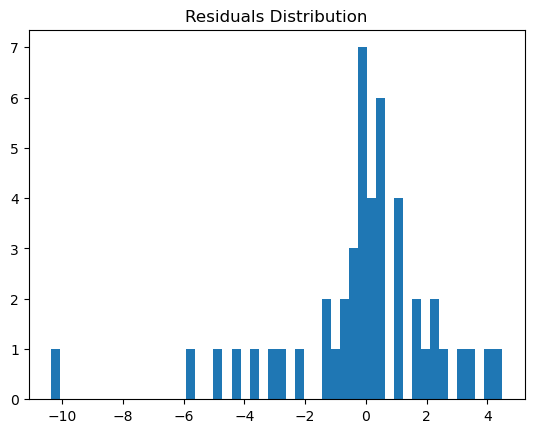

count    232.000000
mean       9.358707
std        4.302948
min        0.990000
25%        5.940000
50%        8.910000
75%       13.860000
max       13.860000
Name: Total, dtype: float64

In [53]:
X = df.drop(columns=['Total']) ##using all other columns to predict total
y = df['Total'] ##total price from invoice

for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category').cat.codes
# X.info()

## train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #uses 80% of data to train and 20% to test
## model 
model = RandomForestRegressor(n_estimators=100, random_state=42) ## random forest on the training data
model.fit(X_train, y_train)
## predict and eval
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred) #root mean squared error (rmse) comparing actual values to predictions
print(f"RMSE: {rmse:.2f}")
# Cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation RMSE: {-scores.mean():.2f}")
# Plotting residuals
residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.title("Residuals Distribution")
plt.show()


##RMSE: 6.76 means predicting total invoice amount is off by $6.76 on average
df['Total'].describe()


In [54]:
# Cross-validation RMSE is the average RMSE obtained from k-fold cross-validation (in your case, 5 folds). 
# It gives a more robust estimate of model performance because it accounts for variability 
# in the data by evaluating the model on different subsets.
# A high cross-validation RMSE (38.71) relative to the original RMSE (6.76) 
# indicates that your model might be overfitting the training data, meaning 
# it's performing well on the training set but poorly on unseen data. This could be due to:
# Overfitting: The model has learned specific patterns in the training data that don't generalize well to new data.
# Data leakage: Some features might be causing the model to "cheat" by picking up patterns that won't hold in unseen data.
# Inadequate feature engineering: The features might not fully capture the variability needed for the model to generalize well.

In [55]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, None],      # Max depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Corrected values for max_features
    'bootstrap': [True, False]        # Whether to use bootstrap sampling 
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           cv=5,  # 5-fold cross-validation
                           n_jobs=-1,  # Use all available cores
                           scoring='neg_mean_squared_error',  # Negate MSE because GridSearchCV tries to maximize
                           verbose=2)  # Print progress

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
print(f"Best Parameters: {grid_search.best_params_}")

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on test data
y_pred = best_rf_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"Best Model RMSE: {rmse:.2f}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Model RMSE: 4.72


In [56]:
# Get feature importances
importances = best_rf_model.feature_importances_

# Sort features by importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# print(feature_importance)

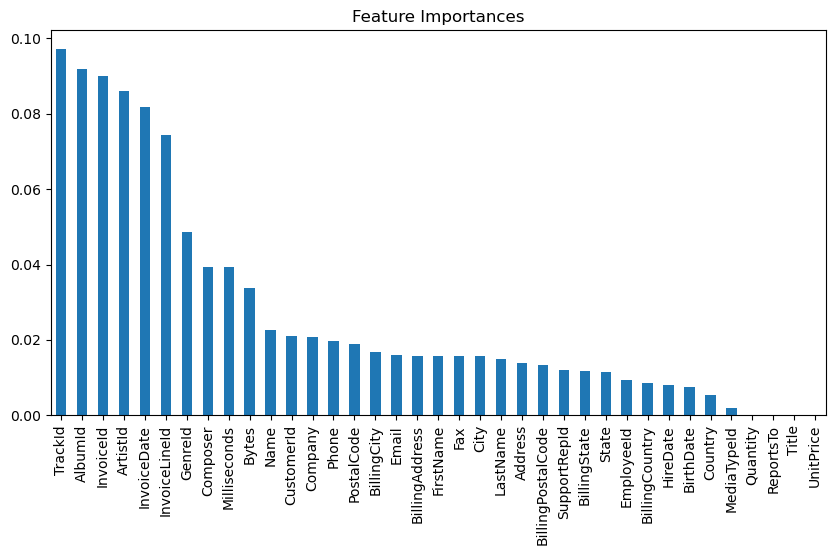

In [57]:
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.title("Feature Importances")
plt.show()

In [58]:
df['Genre_Artist'] = df['GenreId'] * df['ArtistId']

In [59]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

In [60]:

# Train a GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Evaluate
gb_pred = gb_model.predict(X_test)
gb_rmse = mean_squared_error(y_test, gb_pred)
print(f"Gradient Boosting RMSE: {gb_rmse:.2f}")

Gradient Boosting RMSE: 4.60


In [61]:
# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_pred)
print(f"XGBoost RMSE: {xgb_rmse:.2f}")

XGBoost RMSE: 6.04


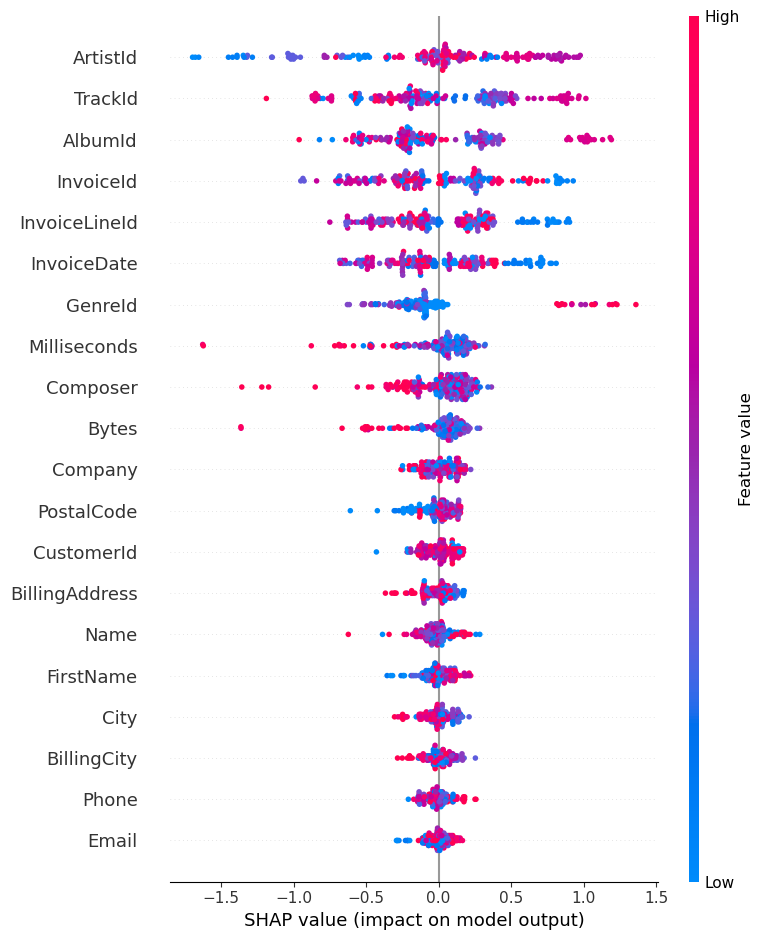

In [62]:

# Use TreeExplainer for tree-based models like RandomForest
explainer = shap.Explainer(best_rf_model)

# SHAP values for a sample of the training data
shap_values = explainer(X_train)

# Summary plot to see global feature importance
shap.summary_plot(shap_values, X_train)

# For a single prediction (e.g., index 0)





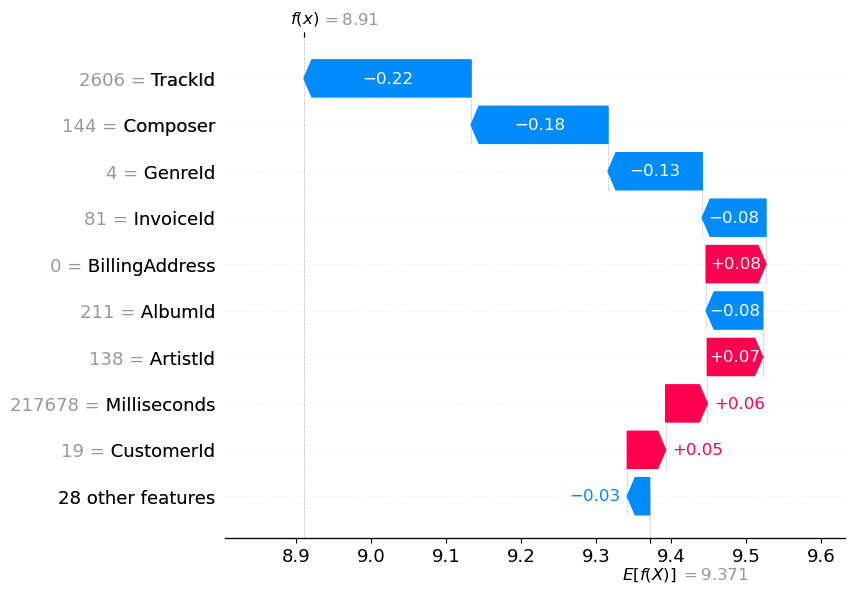

In [63]:
shap.plots.waterfall(shap_values[0])
plt.show()
#SHAP (SHapley Additive exPlanations) assigns each feature a contribution to a prediction. It answers:
#"How much did each feature push the prediction up or down from the model's baseline?"

# Model Prediction (f(x)) = 8.91

# Baseline (E[f(x)]) = 9.371

# So the prediction is lower than average by -0.461

# That means your model was “nudged down” by the specific values in 
# this row — and SHAP is showing us which features were responsible and by how much.
# "This prediction was lower than average because features like trackid, composer, and genreid pushed it down the most. 
# A few others like billingaddress and albumid pulled it slightly up, but not enough to outweigh the rest."
### This is to predict what total invoice will be in the future!

In [64]:
# Save the model
with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)

# Load the model
with open('best_rf_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Predict with the loaded model
y_pred_loaded = loaded_model.predict(X_test)

# Evaluate the loaded model
rmse_loaded = mean_squared_error(y_test, y_pred_loaded)
print(f"Loaded Model RMSE: {rmse_loaded:.2f}")

Loaded Model RMSE: 4.72
